SHOULD FIND COINTEGRATION IN TEST SET ONLY? OR TEST PERIOD ONLY?

THE RISK-ON NOW IS ACTUALLY ONE-SIDE-BIASED: RISK IS ONLY ON WHEN SPREAD WIDENS, I.E., IT'S A SHORT SQUEEZE TRADE

HAVE NOT CODED THE SEPARATION OF REWARD AND RETURNS YET

Instantiate a series of envs, divide that into train_envs and test_envs
- When each env is instantiate:
   - trade(): ratio = S1/S2 -> returns1 = S1/S1.shift; returns2 = S2/S2.shift -> 
   - ma1 = ratio fast mov avg; ma2 = ratio slow moving avg
   - zscore = (ma1 - ma2)/std
   - -> self.df updated with zscore
   - NEED: S1, S2, HR, SPREAD, ROLLING_MEAN, ROLLING_STD, ZSCORE = (SPREAD-ROLLING_MEAN)/ROLLING_STD
   - TO CALCULATE HR: OLS

Initialize policy_net, target_net (by load_state_dict from policy_net), optimizer, memory

Train policy network. For each episode:
- ONLY OUTPUT "TO_TRADE" AND "NOT_TO_TRADE"
- IF "TO_TRADE", NEED A FUNCTION TO CALCULATE "MTM" AS PART OF INFO TO FEED IN TO THE POLICY_NETWORK
- TRADE DIRECTION CAN BE HARDWIRED, E.G., IF ZSCORE IS +VE, LONG S1 SHORT S2
- MAY NEED TO GIVE A SMALL STEP_REWARD ONLY FOR THE DECISION TO TRADE TO ENCOURAGE AGENT TO TRADE - MAY NEED FINE-TUNING
- reset(): done, current_tick, position, positionhistory, total_reward, total_return, history -> get_observation() -> obs (zscore, [self._position.value, self.pvalue]) -> state; here, zscore is zscores for the window size of 60
- select_action based on state, using epsilon-greedy algo: if random > eps threshold, then generate action from policy network; otherwise, random action
- env.step() based on chosen action (converted into Positions) -> obs, reward, done, info -> next_state = obs
   - in step(), loop through 5 trade_periods, return1 = returns1 of the current_tick, return2 = returns2 of the current_tick
   - if action is short, you'll be rewarded if S1 return is -ve, S2 return is +ve
   - if action is long, you'll be rewarded if S1 return is +ve, S2 return is -ve
   - store position in positionhistory
   - sum step_reward as total_reward -> returned in "info"
- pushed to memory: memory.push(state, action, next_state, reward)
- state = next_state
- optimize_model(): 
   - transitions = sample a batch size from memory: memory.sample(BATCH_SIZE)
   - memory -> state_batch, action_batch, reward_batch
   - compute Q(s_t, a) (what the policy_net says based on state_batch): *state_action_values* = policy_net(state_batch)
   - Compute the expected Q values: non_final_mask and non_final_next_state -> next_state_values[non_final_mask] = target_net(non_final_next_states) ->  *expected_state_action_values* = (next_state_values * GAMMA) + reward_batch (from Bellman)
   - compute loss: criterion(state_action_values, expected_state_action_values) -> backprop
   - train_returns from "info"; stored as "total_returns" from df
   - update target network every 5 episodes with policy network parameters: target_net.load_state_dict(policy_net.state_dict())

Validate policy network:
- Instead of using select_action() (epsilon-greedy), use policy_net to generate action directly
- action -> env.step() based on policy_net's action -> obs, _reward, done, info -> state = obs
- test_returns from "info"; stored as "total returns" from df
- avg_rewards = np.mean(test_rewards) -> if avg_rewards > best_rewards -> best_rewards = avg_rewards -> torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

After training, policy_net can be recalled: 
- policy_net.load_state_dict(torch.load('./models/model (6).pth'))
- target_net.load_state_dict(policy_net.state_dict())
- set both nn to eval mode
- for each pair:
   - run it on test_env: loaded policy_net generates action -> obs, reward, done, info -> state = obs
   - render() to render charts
   - returns based on info['total return']



   


_init_ -> trade() -> self.df updated with zscore; self.returns is not invoked elsewhere

reset() invoked in main -> (zscore, [self._position.value, self.pvalue])

step() invoked in main -> take a step based on action returned by nn -> return observation, step_reward, self._done, info

get_observation() -> invoked in reset() -> return np.append(zscore, [self._position.value, self.pvalue])

render() invoked in main -> self.plot_returns_delta(mask), self.plot_prices(mask)

mask is copied from self._positionhistory, which is a list of self._position, which is action returned by nn (as an arg in step()). So, mask has values 0,1,2

plot_returns() -> not used

plot_returns_delta() -> returns1/returns 2 difference, buy/sell signals on top

plot_zscore() -> not used

plot_ratios() -> not used

plot_prices() -> 

Positions: Short(0) Flat(1) Long(2)

based on action, step(action) -> return new obs, _reward, done, info

In [1]:
import os
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

#from stock_trading_environment import StockTradingEnvironment, Positions

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
#copying stock_trading_environment code here for easier editing
#remember to copy back this to the stock_trading environment.py
from gym import spaces
from enum import Enum

class Positions(Enum):   #Python's enum class
    #Short = 0
    #Long = 0
    #Flat = 1
    #Long = 2
    #Short = 2
    Risk_off = 0
    Risk_on = 1


class StockTradingEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, window_size, trade_period):
        super().__init__()

        self.window_size = window_size
        self.trade_period = trade_period
        
        self.trade(data)
        
        # Actions: SHORT(0), FLAT(1), LONG(2)
        #actions: risk_off(0), risk_on(1)
        #self.action_space = spaces.Discrete(3)
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
          low=-np.inf, high=np.inf, shape=(window_size, 1), dtype=np.float16)   #a box as observation space

    #def test(self):
    #    print('testtesttest')
    
    def trade(self, data):
        S1 = data.iloc[:, 0]
        S2 = data.iloc[:, 1]
        _score, self.pvalue, _ = coint(S1, S2)   #probably don't need to include self.pvalue in info; to delete?
        
        #rewriting this block
        '''
        #compare S1 and S2
        #if S1 rolling average price increase > S2's (i.e., diverge), then -1, i.e., short S1
        #if S1 rolling average price increase < S2's (i.e., converge), then 1, i.e., long S1
        #if about the same, then 0
        data['ratios'] = S1/S2
        ma1 = data['ratios'].rolling(window=5, center=False).mean()
        ma2 = data['ratios'].rolling(window=60, center=False).mean()   #hard-coding window of 60
        std = data['ratios'].rolling(window=60, center=False).std()    #hard-coding window of 60
        data['zscore'] = (ma1 - ma2)/std
        #print(data['zscore'])
        
        #can adjust threshold to make it less sensitive
        data['position1'] = np.where(data['zscore'] > 1.5, -1, np.nan)   #S1 too expensive, short S1
        data['position1'] = np.where(data['zscore'] < -1.5, 1, data['position1'])   #S1 too cheap, long S1
        data['position1'] = np.where(abs(data['zscore']) < 0.5, 0, data['position1'])   #neutral
        #data['position1'] = np.where(data['zscore'] > 1000000, -1, np.nan)   
        #data['position1'] = np.where(data['zscore'] < -1000000, 1, data['position1'])
        #data['position1'] = np.where(abs(data['zscore']) < 1000000, 0, data['position1'])


        data['position1'] = data['position1'].ffill().fillna(0)   #padding with zero
        data['position2'] = -np.sign(data['position1'])   #S2 position opposite to S1

        data['returns1'] = np.log(S1/S1.shift(1)).fillna(0)   #S1/S1 = today/yesterday's price
        data['returns2'] = np.log(S2/S2.shift(1)).fillna(0)   #S2/S2
        #half-half strategy: if position not zero, then half long one and half short the other one
        #strategy actually not used elsewhere, but need to keep in df
        data['strategy'] = 0.5*(data['position1'].shift(1) * data['returns1']) + 0.5*(data['position2'].shift(1) * data['returns2'])
        #print(data['strategy'])'''

        #run OLS regression
        ols_model=OLS(S1, S2).fit()
        #get pair's hedge ratio
        self._hr = ols_model.params[0]
            
        #calculate spread
        data['spread'] = np.log(S1) - self._hr * np.log(S2)
        #data['spread'] = S1 - self._hr * S2

        #calculate rolling mean
        data['roll_mean'] = data['spread'].rolling(window=self.window_size, center=False).mean()

        #calculate rolling std
        data['roll_std'] = data['spread'].rolling(window=self.window_size, center=False).std()

        #calculate zscore
        data['zscore'] = (data['spread'] - data['roll_mean'])/data['roll_std']
        
        #exclude the first window length
        self.df = data.iloc[self.window_size:]
        #self.df = data.iloc[60:]   #hard-coding window of 60?
        #self.returns = self.df[['returns1', 'returns2', 'strategy']].dropna().cumsum().apply(np.exp).tail(1)   #tail - last item
        #print(self.returns)
        #return self.returns   #new
        #print('testtestets')

    def reset(self):
        self._done = False
        self._current_tick = self.window_size
        #self._position = Positions.Flat
        self._position = Positions.Risk_off
        self._positionhistory = []
        self._total_reward = 0.0
        self._total_return = 0.0
        self._return = 0.0   #new
        self.history = {}
        return self.get_observation()
    
    def step(self, action):
        step_reward = 0
        #print(f'self._position: {self._position}')
        #print(f'action: {action}')

        if self._position == Positions.Risk_off:
            if action == Positions.Risk_off:
                step_reward = 0
            else:
                self._trade_record = self.enter_trade(self._current_tick)
                step_reward = 0
                #step_reward = 0.1   #some reward to encourage taking risk
                #step_reward = -1   #transaction cost to discourage trading   ###changed###
                self._position = Positions.Risk_on

        elif self._position == Positions.Risk_on:
            if action == Positions.Risk_on:
                step_reward = 0
            else:
                self._return = self.exit_trade(self._trade_record)
                
                #penalize frequent trading of less than a week
                if self._current_tick - self._trade_record[2] <= 5:
                    step_reward = self._return * 0.9
                else:
                    step_reward = self._return
                #print(f'PnL: {self._pnl}')
                self._position = Positions.Risk_off

        #rewriting this block
        '''for i in range(self.trade_period):   #trade_period = 5 = one step
            return1 = self.df.loc[self.df.index[self._current_tick], 'returns1']   #loop current tick through window size
            return2 = self.df.loc[self.df.index[self._current_tick], 'returns2']
            if self._position == Positions.Short:
                step_reward += -0.5 * return1 + 0.5 * return2   #if Positions is Short, step_reward = -S1 return +S2 return
                #if action is short, you'll be rewarded if S1 return is -ve, S2 return is +ve
            elif self._position == Positions.Long:
                step_reward += 0.5 * return1 - 0.5 * return2    #if Positions is Long, step_reward = +S1 return -S2 return
                #if action is long, you'll be rewarded if S1 return is +ve, S2 return is -ve
            self._current_tick += 1
            self._positionhistory.append(self._position.value)'''
        
        #print(f'step_reward: {step_reward}')
        self._current_tick += 1
        self._positionhistory.append(self._position.value)

        self._position = action   #update self._position with action returned by nn
        #self._done = (self._current_tick + self.trade_period > self.df.shape[0])
        self._done = (self._current_tick + 1 > self.df.shape[0])   #new; no longer need trade_period
        
        self._total_reward += step_reward
        self._total_return += self._return
        
        observation = self.get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_return = self._total_return
        )

        return observation, step_reward, self._done, info
        #return observation, step_reward, self._done
    
    
    def get_observation(self):
        end_index = self._current_tick
        start_index = end_index - self.window_size
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')].values   #zscore = (spread-roll+mean)/roll_std
        return np.append(zscore, [self._position.value, float(self.pvalue)])   #60 zscores + _position.value + pvalue = 62 items in each obs
        #return np.append(zscore, [self._position.value, self._current_tick])   #60 zscores + _position.value + _current_tick = 62 items in each obs


    def enter_trade(self, current_tick):
        #+ve and -ve directions are a bit counter-intuitive below
        #the logic is: if you short/sell something, your cash level increases by the price
        #if you long/buy something, your cash level decreases by the price
        #this is just for easier calculations: say you short $100 and later it drops to $90, the pnl is +$100-$90=+$10
        #say you long $90 and later it increases to $110, the pnl is -$90+$110=+$20
        #adjusted by hedge ratio

        if self._hr >= 1:   #S1 more expensive than S2; should short S1 long S2
            self._S1_entry_price = self.df.loc[self.df.index[self._current_tick]][0]               #short/sell
            self._S2_entry_price = -self._hr * self.df.loc[self.df.index[self._current_tick]][1]   #long/buy
        
        else:   #S2 more expensive than S1; should long S1 short S2
            self._S1_entry_price = -self.df.loc[self.df.index[self._current_tick]][0]             #long/buy
            self._S2_entry_price = self._hr * self.df.loc[self.df.index[self._current_tick]][1]   #short/sell

        return [self._S1_entry_price, self._S2_entry_price, current_tick]
    

    def exit_trade(self, trade_record):
        
        if self._hr >= 1:   #S1 more expensive than S2; should short S1 long S2 initially
            #unwind: buy S1 sell S2
            pnl = (trade_record[0] - self.df.loc[self.df.index[self._current_tick]][0]) + \
                (trade_record[1] + self._hr * self.df.loc[self.df.index[self._current_tick]][1])
        
        else:   #S2 more expensive than S1; should long S1 short S2 initially
            #unwind: sell S1 buy S2
            pnl = (trade_record[0] + self.df.loc[self.df.index[self._current_tick]][0]) + \
                (trade_record[1] - self._hr * self.df.loc[self.df.index[self._current_tick]][1])

        #should not penalize here    
        #penalize frequent trading of less than a week
        #if self._current_tick - trade_record[2] <= 5:
        #    pnl = pnl*0.9

        return pnl
           
    
    def render(self, mode='human', close=False):
        start_index = self.window_size
        #start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        #mask = pd.Series(self._positionhistory, index=self.df.index[start_index:end_index])
        #mask = pd.DataFrame(self._positionhistory, index=self.df.index[start_index:end_index])    ###changed###
        #short_mask = pd.Series(self._positionhistory[-244:], index=self.df.index[-244:])   #created to shorten the plot     
        short_mask = pd.DataFrame(self._positionhistory[-244:], index=self.df.index[-244:])   #newly created to plot twists
        
        #new
        short_mask['shift'] = short_mask[0].shift(1).fillna(0)
        short_mask['diff'] = short_mask[0] - short_mask['shift']
        #if diff = +1, from 0 to 1, trade, risk_on
        #if diff = 0, from 0 to 0, or 1 to 1, no trade
        #if diff = -1, from 1 to 0, trade, risk_off


        #self.plot_returns_delta(mask)
        #self.plot_prices(mask)
        #print(short_mask['diff'].unique())
        self.plot_short_prices(short_mask['diff'])
        

        #mask['shift'] = mask[0].shift(1).fillna(0)
        #mask['diff'] = mask[0] - mask['shift']
        #print(mask['diff'].unique())
        #self.plot_short_prices(mask['diff'])


    def plot_returns(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]
        zscore.plot()
        
        buy = zscore.copy()
        sell = zscore.copy()
        
        buy[mask==Positions.Risk_off.value] = -np.inf
        sell[mask==Positions.Risk_on.value] = -np.inf
        #buy[mask==Positions.Flat.value] = -np.inf
        #sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Zscore', 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_returns_delta(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]      ### NEW ###
        
        #return1 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('return1')]
        #return2 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('return2')]
        return1 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('returns1')]   ### NEW ###
        return2 = self.df.iloc[start_index:end_index, self.df.columns.get_loc('returns2')]   ### NEW ###
        returns_delta = return1 - return2
        returns_delta.plot()
        
        buy = returns_delta.copy()
        sell = returns_delta.copy()
        
        buy[mask==Positions.Risk_on.value] = -np.inf
        sell[mask==Positions.Risk_off.value] = -np.inf
        #buy[mask==Positions.Flat.value] = -np.inf
        #sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Returns Delta', 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_zscore(self, mask):
        plt.figure(figsize=(12,6))
        
        #start_index = self.window_size
        start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        zscore = self.df.iloc[start_index:end_index, self.df.columns.get_loc('zscore')]
        zscore.plot()
        
        buy = zscore.copy()
        sell = zscore.copy()
        
        buy[mask==Positions.Short.value] = -np.inf
        sell[mask==Positions.Long.value] = -np.inf
        buy[mask==Positions.Flat.value] = -np.inf
        sell[mask==Positions.Flat.value] = -np.inf
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, zscore.min(), zscore.max()))
        
        plt.legend(['Zscore', 'Buy Signal', 'Sell Signal'])
        plt.show()
    
    def plot_ratios(self, mask):
        plt.figure(figsize=(12,6))
        
        start_index = self.window_size
        end_index = start_index + len(self._positionhistory)
        ratios = self.df.iloc[start_index:end_index, self.df.columns.get_loc('ratios')]
        ratios.plot()
        
        buy = 0*ratios.copy()
        sell = 0*ratios.copy()
        
        buy[mask==Positions.Long.value] = ratios[mask==Positions.Long.value]
        sell[mask==Positions.Short.value] = ratios[mask==Positions.Short.value]
        
        buy.plot(color='r', linestyle='None', marker='^')
        sell.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, ratios.min(), ratios.max()))
        
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()
    
    def plot_prices(self, mask):
        plt.figure(figsize=(16,6))

        start_index = self.window_size
        #start_index = len(self._positionhistory) - 244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        S1 = self.df.iloc[start_index:end_index, 0]
        S2 = self.df.iloc[start_index:end_index, 1]
        #print(S1)
        #print(S2)
        
        S1.plot(color='b')
        S2.plot(color='c')
        buyR = 0*S1.copy()
        sellR = 0*S1.copy()

        # When you buy the ratio, you buy stock S1 and sell S2
        buyR[mask==Positions.Long.value] = S1[mask==Positions.Long.value]
        sellR[mask==Positions.Long.value] = S2[mask==Positions.Long.value]

        # When you sell the ratio, you sell stock S1 and buy S2
        buyR[mask==Positions.Short.value] = S2[mask==Positions.Short.value]
        sellR[mask==Positions.Short.value] = S1[mask==Positions.Short.value]

        buyR.plot(color='r', linestyle='None', marker='^')
        sellR.plot(color='g', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

        plt.legend([S1.name, S2.name, 'Buy Signal', 'Sell Signal'])
        plt.show()

    def plot_short_prices(self, mask):
        plt.figure(figsize=(16,6))

        start_index = self.window_size
        #short_start_index = len(self._positionhistory) - 244   #to shorten the plot
        short_start_index = -244   #to shorten the plot
        end_index = start_index + len(self._positionhistory)
        #S1 = self.df.iloc[start_index:end_index, 0]
        #S2 = self.df.iloc[start_index:end_index, 1]
        S1 = self.df.iloc[short_start_index:end_index, 0]
        S2 = self.df.iloc[short_start_index:end_index, 1]
        #print(S1)
        #print(S2)
        
        S1.plot(color='b')
        S2.plot(color='c')
        #buyR = 0*S1.copy()
        #sellR = 0*S1.copy()
        buy_ron = 0*S1.copy()
        sell_ron = 0*S1.copy()
        buy_roff = 0*S1.copy()
        sell_roff = 0*S1.copy()

        #if diff = +1, from 0 to 1, trade, risk_on
        #if diff = 0, from 0 to 0, or 1 to 1, no trade
        #if diff = -1, from 1 to 0, trade, risk_off
        if self._hr >= 1:   #S1 more expensive than S2; should short S1 long S2
            #risk_on
            sell_ron[mask==1] = S1[mask==1]
            buy_ron[mask==1] = S2[mask==1]

            #risk_off
            buy_roff[mask==-1] = S1[mask==-1]
            sell_roff[mask==-1] = S2[mask==-1]


        else:   #S2 more expensive than S1; should long S1 short S2
            #risk_on
            buy_ron[mask==1] = S1[mask==1]
            sell_ron[mask==1] = S2[mask==1]

            #risk_off
            sell_roff[mask==-1] = S1[mask==-1]
            buy_roff[mask==-1] = S2[mask==-1]


        #rewriting this block
        '''# When you buy the ratio, you buy stock S1 and sell S2
        #buyR[mask==Positions.Long.value] = S1[mask==Positions.Long.value]
        #sellR[mask==Positions.Long.value] = S2[mask==Positions.Long.value]
        #buyR[mask==Positions.Risk_on.value] = S1[mask==Positions.Risk_on.value]
        #sellR[mask==Positions.Risk_on.value] = S2[mask==Positions.Risk_on.value]
        buyR[mask==0] = S1[mask==0]
        sellR[mask==0] = S2[mask==0]
        #print(buyR)
        #print(sellR)
        
        # When you sell the ratio, you sell stock S1 and buy S2
        buyR[mask==1] = S2[mask==1]
        sellR[mask==1] = S1[mask==1]'''

        buy_ron.plot(color='g', linestyle='None', marker='^')
        sell_ron.plot(color='r', linestyle='None', marker='v')
        buy_roff.plot(color='g', linestyle='None', marker='x')
        sell_roff.plot(color='r', linestyle='None', marker='x')
        #buyR.plot(color='g', linestyle='None', marker='^')
        #sellR.plot(color='r', linestyle='None', marker='v')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

        plt.legend([S1.name, S2.name, 'Buy Risk-on', 'Sell Risk-on', 'Buy Risk-off', 'Sell Risk-off'])
        plt.show()

        

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    hr = []
    for i in range(n):
        for j in range(i+1, n):
            df = data[[keys[i], keys[j]]].dropna()
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2)    #statsmodel built-in cointegration hypothesis test
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue

            #run OLS regression
            ols_model=OLS(S1, S2).fit()
            #get pair's hedge ratio
            hr_pair = ols_model.params[0]
            
            #calculate spread
            spread = np.log(S1) - hr_pair * np.log(S2)
            #spread = S1 - hr_pair * S2   ###changed###

            #adf
            # conduct Augmented Dickey-Fuller test
            adf = adfuller(spread, maxlag = 1)
        
            #if pvalue < 0.05 :    #reject null: there should be cointegration
            #add one condition: adf needs to < -3.435 to confirm stationarity
            if (pvalue < 0.05 and adf[0] < -3.435):    #reject null: there should be cointegration
                pairs.append((keys[i], keys[j]))
                
                #append hr_pair into hr list
                hr.append(hr_pair)
     
    return score_matrix, pvalue_matrix, hr, pairs


def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [8]:
#this block seems no use?

# directory = './data/主题行业类'
# data_pairs = []
# for filename in os.listdir(directory):
#     df = pd.read_excel(os.path.join(directory, filename), header=1, index_col=0, skiprows=0)
#     _, _, _, pairs = find_cointegrated_pairs(df)
#     data_pairs.extend([df[list(pair)].dropna().copy() for pair in pairs])

# print(len(data_pairs))

224


In [97]:
#Plot the spread
# ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
# ax.set_ylabel("Spread")
# ax.grid(True);
# plt.show()

<Axes: title={'center': "Pair's Spread"}, xlabel='Date', ylabel='Spread'>

[('603919.SH', '600059.SH'), ('603779.SH', '600543.SH'), ('603779.SH', '600365.SH'), ('603589.SH', '002304.SZ'), ('603198.SH', '600059.SH'), ('601579.SH', '600543.SH'), ('600616.SH', '600543.SH'), ('600616.SH', '000995.SZ'), ('600616.SH', '000752.SZ'), ('600573.SH', '000929.SZ'), ('600543.SH', '000995.SZ'), ('600543.SH', '000929.SZ'), ('600059.SH', '002568.SZ'), ('600059.SH', '002304.SZ'), ('600059.SH', '000869.SZ'), ('002461.SZ', '000995.SZ')]


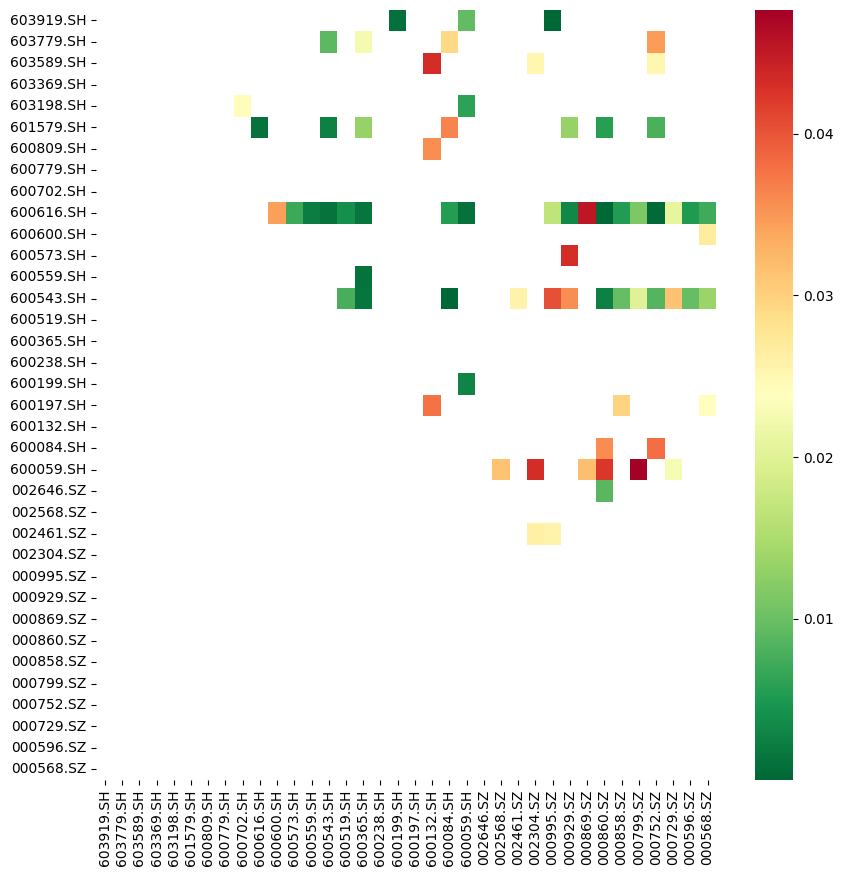

In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
df = pd.read_excel('./data/主题行业类/酒类.xlsx', header=1, index_col=0, skiprows=0)
tickers = df.columns
scores, pvalues, hr, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues >= 0.05))
print(pairs)

In [12]:
window_size = 60
trade_period = 5

envs = []
for pair in pairs:
    data = df[list(pair)].dropna()
    if data.shape[0] > 700:
        envs.append(StockTradingEnvironment(data.copy(), window_size, trade_period))   #instantiate an env; automatatically run trade()

train_size = int(len(envs) * 0.7)   #train/test split = 0.7
#print(train_size)
train_envs = envs[:train_size]
test_envs = envs[train_size:]

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):   #PyTorch's Module class

    def __init__(self, input_size, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, n_actions)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.model(x.to(device))

In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
#n_actions = 3
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)   #decreasing from 1 to 0.36xxx
    steps_done += 1
    if sample > eps_threshold:   #epsilon-greedy
        with torch.no_grad():   #disable tracking of grad in autograd; reduce memory usage and speed up computations; no backprop
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net(state)).max(1)
            return policy_net(state).max(1)[1].view(1, 1)   #exploit
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)   #explore, because random

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:   #min memory = 128
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))   #batch is a namedtuple; tuple (state, action, next_state, reward) from memory

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,   #lambda s: s is not None will return a tuple of bools over bench.next_state
                                          batch.next_state)), device=device, dtype=torch.bool)   #next_state is an observation
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #Q(s_t, a) is what the policy_net says based on state_batch
    state_action_values = policy_net(state_batch).gather(1, action_batch)   #gather from policy_net(state_batch) (axis, index)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)   #initialize next_state_values
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()   #what target_net says
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch   
    #Bellman equation: expected state_action values (from target network) * GAMMA + immediate reward should equal to
    #state_action values returned by policy network; difference = loss

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()   #set optimizer's grad to zero
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)   #clamp_ is inplace version of clamp: clamp grad.data into -1 and 1 range
    optimizer.step()   #update parameters of optimizer

In [17]:
#num_episodes = 5
#num_episodes = 50
num_episodes = 300
best_rewards = -10
for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []
    for env in train_envs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = env.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)   
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = select_action(state)   #epsilon-greedy: exploit or explore; state is this state
            obs, reward, done, info = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each status means 60 past zscores + current action + pvalue  
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            #new
            #train_rewards.append(reward)


            # Perform one step of the optimization (on the policy network)
            optimize_model()   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    test_rewards = []
    test_returns = []
    with torch.no_grad():
        for env in test_envs:
            obs = env.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, _reward, done, info = env.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                if done:
                    test_rewards.append(info['total_reward'])
                    test_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(test_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(test_rewards),
           np.mean(test_returns)))
    #print('epoch [{}/{}], train rewards:{:.4f}, val rewards:{:.4f}'.format
    #      (i_episode + 1, num_episodes, np.mean([float(x) for x in train_rewards]), #not all in train_rewards are torch.Tensor
    #       np.mean([float(x) for x in test_rewards])))
           #np.mean(np.sum([float(x) for x in test_rewards]))))


print('Complete')

epoch [1/300], train rewards:-20.7878, returns:-340.3882, val rewards:-8.2092, returns:110.1212
epoch [2/300], train rewards:-20.6766, returns:-177.1598, val rewards:-6.9706, returns:-75.2115
epoch [3/300], train rewards:-15.6333, returns:-195.0723, val rewards:0.6307, returns:222.2539
epoch [4/300], train rewards:-14.8342, returns:-172.6934, val rewards:-7.5340, returns:97.2097
epoch [5/300], train rewards:-19.5473, returns:-253.9448, val rewards:-2.5157, returns:231.9422
epoch [6/300], train rewards:-17.3517, returns:-273.0343, val rewards:-7.5600, returns:-178.9269
epoch [7/300], train rewards:-21.0849, returns:-275.9471, val rewards:-1.8272, returns:293.2080
epoch [8/300], train rewards:-23.5530, returns:-330.0047, val rewards:-4.8402, returns:-17.9754
epoch [9/300], train rewards:-19.1992, returns:-201.0811, val rewards:2.0621, returns:102.0668
epoch [10/300], train rewards:-17.4556, returns:-310.4798, val rewards:-5.1403, returns:-13.2107
epoch [11/300], train rewards:-17.5833, r

In [45]:
#shows that not all in train_rewards are torch.Tensor
#all(isinstance(train_rewards, torch.Tensor) for x in train_rewards)

False

action = tensor[0] or [1] or [2]

obs = get_observation

reward = step_reward += -0.5 * return1 + 0.5 * return2    #Positions.Short, then step_reward = short S1 long S2

reward = step_reward += 0.5 * return1 - 0.5 * return2    #Positions.Long, then step_reward = long S1 short S2

done = bool

info = dict: total_reward, total_return

state = 62 states

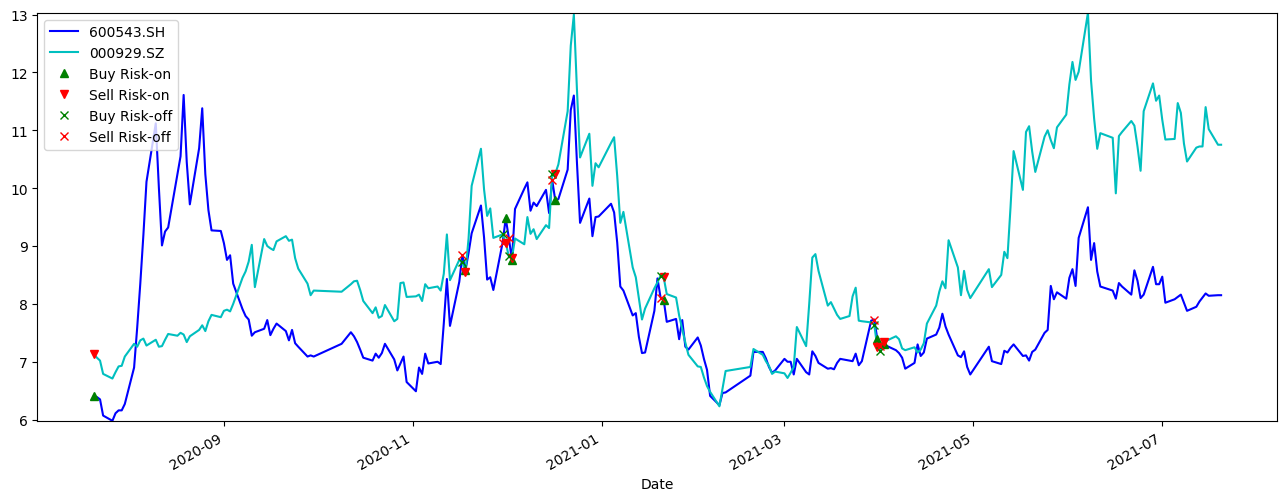

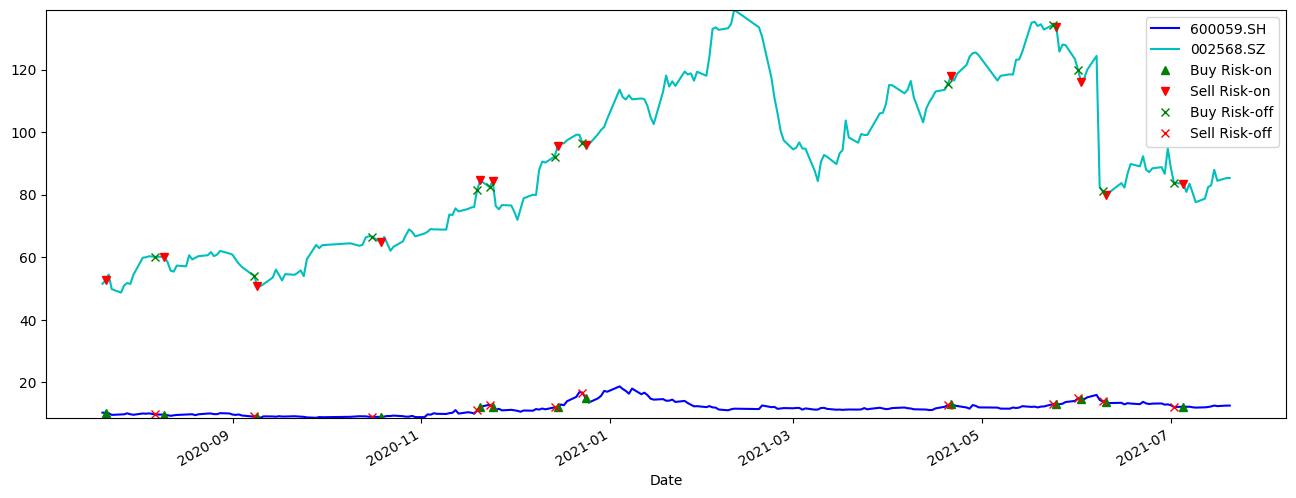

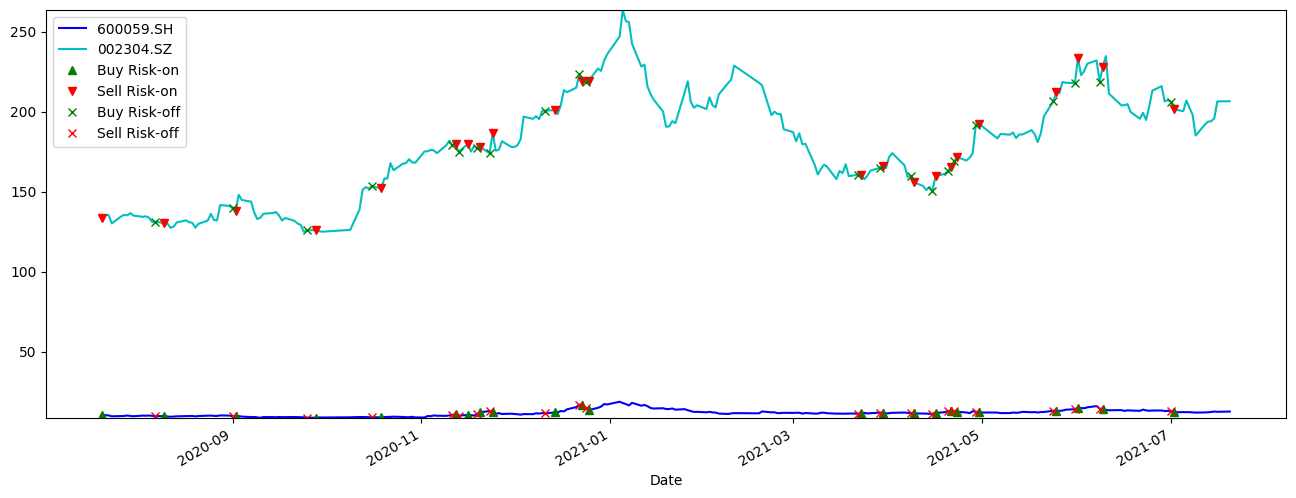

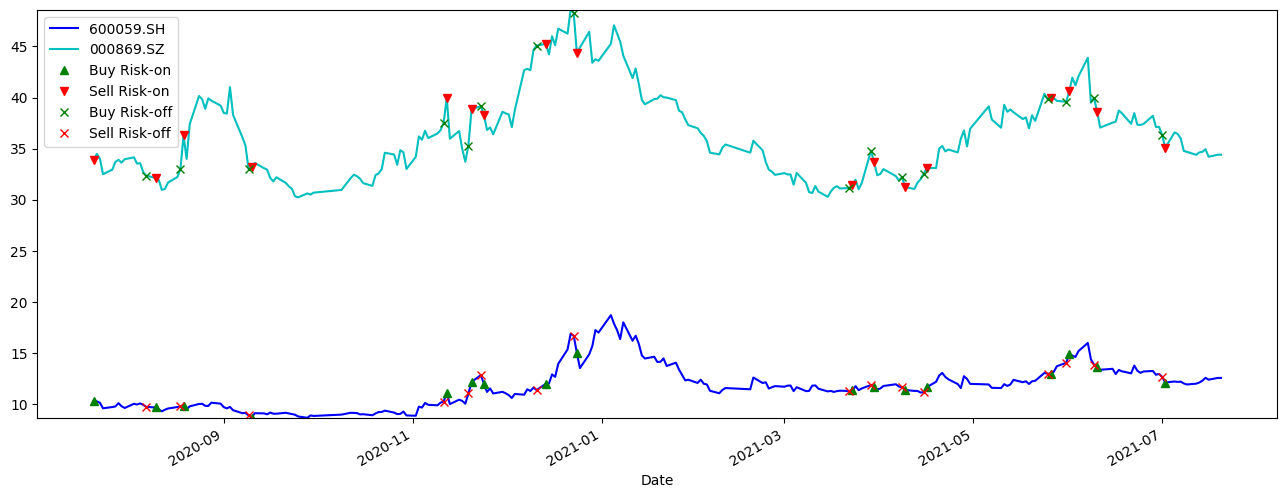

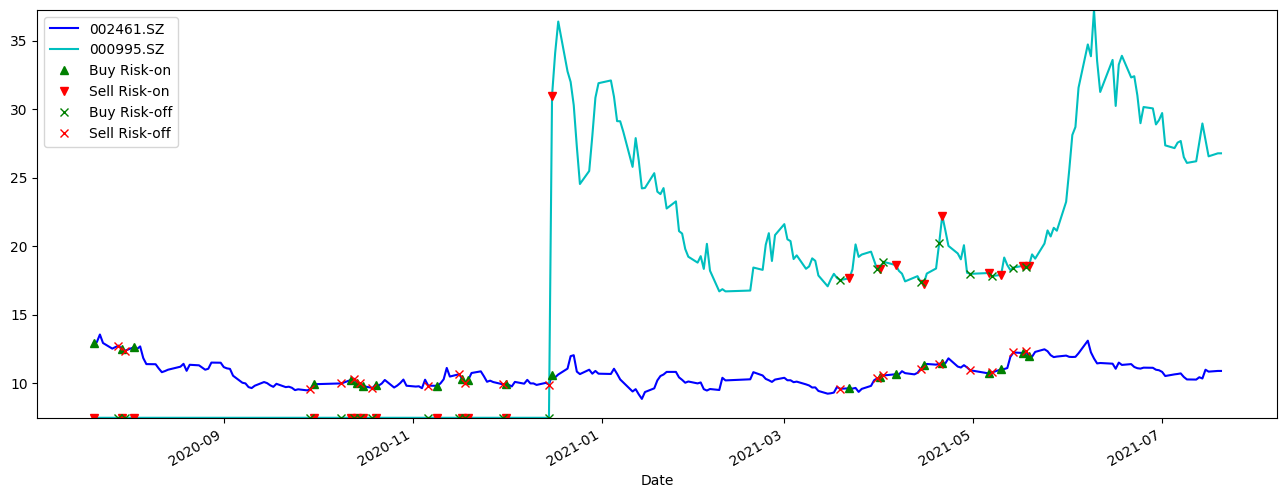

average returns: 32.086256318611426


In [18]:
#policy_net.load_state_dict(torch.load('./models/model (19).pth'))
#policy_net.load_state_dict(torch.load('./models/model (6).pth'))   #copies parameters from state_dict to this module
policy_net.load_state_dict(torch.load('./models/model (13).pth'))   #newly saved model under "Mar18_new trial"
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

#returns = []
total_returns = []
with torch.no_grad():
    #for env in train_envs:
    for env in test_envs:
    #for env in [test_envs[1]]:

        obs = env.reset()
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, reward, done, info = env.step(Positions(action.item()))
            #obs, reward, done = env.step(Positions(action.item()))
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            #print(state)
            
            #new
            #print(f'reward: {reward}')
            #returns.append(reward)

            if done:
                #print(f'env.returns\n{env.returns}')
                #print(f'env.total_reward{env._total_reward}')
                env.render()
                #total_returns.append(returns)   ###changed###
                #print(f'returns: {np.sum(returns)}')   ###changed###
                #total_returns.append(np.sum(returns))   ###changed###
                #print(f'len(returns): {len(returns)}')
                total_returns.append(info['total_return'])
                break

#print(f'returns: {returns}')
#avg_returns = np.mean(returns)
#print(f'average returns: {np.mean(np.sum(total_returns))}')
print(f'average returns: {np.mean(total_returns)}')

plt.ioff()
plt.show()

In [72]:
test_envs[0]._pnl

-0.36853491920708414

In [97]:
for i in range(16):
    print(np.unique(np.array(envs[i]._positionhistory)))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]


In [98]:
#short_mask
mask = pd.Series(envs[0]._positionhistory[-244:], index=envs[0].df.index[-244:])

In [99]:
mask

Date
2020-07-21    0
2020-07-22    0
2020-07-23    0
2020-07-24    1
2020-07-27    1
             ..
2021-07-14    1
2021-07-15    0
2021-07-16    0
2021-07-19    0
2021-07-20    0
Length: 244, dtype: int64

In [89]:
S1 = envs[0].df.iloc[-244:, 0]
buyR = 0*S1.copy()

In [90]:
buyR

Date
2020-07-21    0.0
2020-07-22    0.0
2020-07-23    0.0
2020-07-24    0.0
2020-07-27    0.0
             ... 
2021-07-14    0.0
2021-07-15    0.0
2021-07-16    0.0
2021-07-19    0.0
2021-07-20    0.0
Name: 603919.SH, Length: 244, dtype: float64

In [95]:
S1[mask==1]
        

Date
2020-07-24    16.00
2020-07-27    16.50
2020-07-28    17.24
2020-08-05    17.41
2020-08-06    17.10
              ...  
2021-06-22    43.39
2021-07-06    40.10
2021-07-07    41.67
2021-07-08    40.28
2021-07-14    42.31
Name: 603919.SH, Length: 81, dtype: float64

In [21]:
test_envs[0].df

,600543.SH,000858.SZ,ratios,zscore,position1,position2,returns1,returns2,strategy
Date,,,,,,,,,
2010-04-06,12.00,28.04,0.427960,-0.043434,0.0,-0.0,-0.014889,-0.009230,0.0
2010-04-07,11.88,28.36,0.418900,-0.028455,0.0,-0.0,-0.010050,0.011348,-0.0
2010-04-08,11.91,27.76,0.429035,-0.023734,0.0,-0.0,0.002522,-0.021384,0.0
2010-04-09,12.05,28.05,0.429590,0.025610,0.0,-0.0,0.011686,0.010392,0.0
2010-04-12,12.19,27.52,0.442951,0.195577,0.0,-0.0,0.011551,-0.019076,0.0
...,...,...,...,...,...,...,...,...,...
2021-07-14,8.11,275.30,0.029459,1.192199,0.0,-0.0,0.008669,-0.002539,0.0
2021-07-15,8.18,280.83,0.029128,1.116917,0.0,-0.0,0.008594,0.019888,0.0
2021-07-16,8.14,277.52,0.029331,1.081904,0.0,-0.0,-0.004902,-0.011857,0.0


In [30]:
env.plot_ratios(mask)

NameError: name 'mask' is not defined

In [26]:
env.get_observation()

array([ 1.6456393 ,  1.69994203,  1.6121919 ,  1.17116738,  0.70791341,
        0.49220369,  0.28231175,  0.33163876,  0.52578213,  0.81065002,
        0.8498165 ,  0.89961637,  0.95076599,  1.12619571,  0.93018687,
        0.85288347,  1.03540377,  1.20477318,  1.33735685,  1.6424206 ,
        1.79683237,  1.6296441 ,  1.50297121,  1.32210901,  0.99042736,
        0.73686185,  0.50510593,  0.17612378, -0.23804205, -0.6849999 ,
       -1.19995276, -1.59894898, -2.02059621, -2.26660196, -2.38129286,
       -2.41575328, -2.41616669, -2.32770175, -2.26648371, -2.1578047 ,
       -1.98273385, -1.88796502, -1.83248792, -1.74408091, -1.70426996,
       -1.59812967, -1.49019038, -1.41646325, -1.31331564, -1.24064728,
       -1.22550451, -1.16383018, -1.09472096, -1.04982904, -0.99667683,
       -0.91658065, -0.87238548, -0.84401098, -0.82711078, -0.84182319,
        0.        ,  0.02573553])